## SMPL Model Pose2Mesh

In [13]:
import transforms3d
import numpy as np
import torch
import os.path as osp
import json

from smplpytorch.smplpytorch.pytorch.smpl_layer import SMPL_Layer

In [14]:
class SMPL(object):
    def __init__(self):
        self.layer = {'male': self.get_layer('male'), 'female': self.get_layer('female'),
                      'neutral': self.get_layer('neutral')}
        self.vertex_num = 6890
        self.face = self.layer['neutral'].th_faces.numpy()
        self.joint_regressor = self.layer['neutral'].th_J_regressor.numpy().astype(np.float32)  # smpl joint regressor
        self.joint_regressor_h36m = np.load(osp.join('./data', 'J_regressor_h36m_correct.npy')).astype(np.float32)
        #  'J_regressor_coco_use_extra_joint.npy' 'J_regressor_coco_all_smpl_joint.npy'
        # add nose, L/R eye, L/R ear
        self.face_kps_vertex = (331, 2802, 6262, 3489, 3990)  # mesh vertex idx
        nose_onehot = np.array([1 if i == 331 else 0 for i in range(self.joint_regressor.shape[1])],
                               dtype=np.float32).reshape(1, -1)
        left_eye_onehot = np.array([1 if i == 2802 else 0 for i in range(self.joint_regressor.shape[1])],
                                   dtype=np.float32).reshape(1, -1)
        right_eye_onehot = np.array([1 if i == 6262 else 0 for i in range(self.joint_regressor.shape[1])],
                                    dtype=np.float32).reshape(1, -1)
        left_ear_onehot = np.array([1 if i == 3489 else 0 for i in range(self.joint_regressor.shape[1])],
                                   dtype=np.float32).reshape(1, -1)
        right_ear_onehot = np.array([1 if i == 3990 else 0 for i in range(self.joint_regressor.shape[1])],
                                    dtype=np.float32).reshape(1, -1)
        self.joint_regressor = np.concatenate(
            (self.joint_regressor, nose_onehot, left_eye_onehot, right_eye_onehot, left_ear_onehot, right_ear_onehot))

        self.joint_num = 29  # original: 24. manually add nose, L/R eye, L/R ear
        self.joints_name = (
        'Pelvis', 'L_Hip', 'R_Hip', 'Torso', 'L_Knee', 'R_Knee', 'Spine', 'L_Ankle', 'R_Ankle', 'Chest', 'L_Toe',
        'R_Toe', 'Neck', 'L_Thorax', 'R_Thorax', 'Head', 'L_Shoulder', 'R_Shoulder', 'L_Elbow', 'R_Elbow', 'L_Wrist',
        'R_Wrist', 'L_Hand', 'R_Hand', 'Nose', 'L_Eye', 'R_Eye', 'L_Ear', 'R_Ear')
        self.part_segments_color = ('silver', 'blue', 'green', 'salmon', 'turquoise', 'olive', 'lavender', 'darkblue', 'lime', 'khaki', 'cyan', 'darkgreen',
                                    'beige', 'coral', 'crimson', 'red', 'aqua', 'chartreuse', 'indigo', 'teal', 'violet', 'orchid', 'orange', 'gold')
        self.flip_pairs = (
        (1, 2), (4, 5), (7, 8), (10, 11), (13, 14), (16, 17), (18, 19), (20, 21), (22, 23), (25, 26), (27, 28))
        self.skeleton = (
        (0, 1), (1, 4), (4, 7), (7, 10), (0, 2), (2, 5), (5, 8), (8, 11), (0, 3), (3, 6), (6, 9), (9, 14), (14, 17),
        (17, 19), (21, 23), (9, 13), (13, 16), (16, 18), (18, 20), (20, 22), (9, 12), (12, 24), (24, 14), (24, 25),
        (24, 26), (25, 27), (26, 28))
        self.root_joint_idx = self.joints_name.index('Pelvis')

    def get_layer(self, gender):
        gender='neutral'
        return SMPL_Layer(gender=gender, model_root='../smpl_models/')

## Prepocess Data Human 3.6M

In [15]:
import numpy as np
import os
import os.path as osp
import pickle as pkl
import json
from PIL import Image
import torch
from modules.smpl_model.config_smpl import *

In [16]:
def get_cam_pose_intr(cam_dict):
    cam_pose = torch.cat((torch.FloatTensor(cam_dict['R']), torch.FloatTensor(cam_dict['t'])[:,None]), dim = 1)
    cam_pose = torch.cat((cam_pose, torch.FloatTensor([[0, 0, 0, 1]])), dim=0)
    cam_intr = torch.zeros(3,3)
    cam_intr[0,0], cam_intr[1,1] = cam_dict['f']
    cam_intr[0:2,2] = torch.tensor(cam_dict['c'])
    cam_intr[2,2] = 1.
    return {'cam_pose': cam_pose, 'cam_intr': cam_intr}

In [17]:
def get_fitting_error(joint3d_h36m_gt, joint3d_smpl):
    joint3d_h36m_gt = joint3d_h36m_gt - joint3d_h36m_gt[H36M_J17_NAME.index('Pelvis'), None,:] # root-relative
    # translation alignment
    joint3d_smpl = joint3d_smpl - np.mean(joint3d_smpl,0)[None,:] + np.mean(joint3d_h36m_gt,0)[None,:]
    error = np.sqrt(np.sum((joint3d_h36m_gt - joint3d_smpl)**2, 1)).mean()
    return error

### Create datalist of all images with smpl params

In [20]:
subject_list = [1, 5, 6, 7, 8, 9, 11]
data_path = '../H36M'
img_dir = osp.join(data_path, 'images')
annot_dir = osp.join(data_path, 'annotations')
fitting_thr = 25  # milimeter --> Threshhold joints from smpl mesh to h36m gt

In [21]:
images = []
cameras = {}
smpl_params = {}
joints = {}
bboxes = {}
for subject in subject_list:
    ### Load image annotations
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_data.json'), 'r') as f:
        annotations = json.load(f)
    images.extend(annotations['images'])
    ### Load cameras
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_camera.json'), 'r') as f:
        cams = json.load(f)
    cameras[str(subject)] = {cam_id: get_cam_pose_intr(cam) for cam_id, cam in cams.items()}
    ### Load fitted smpl parameter
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_smpl_param.json'), 'r') as f:
        smpl_params[str(subject)] = json.load(f)
    ### Load 3d Joint ground truth (17x3)
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_joint_3d.json'), 'r') as f:
        joints[str(subject)] = json.load(f)   

with open(osp.join(annot_dir, 'h36m_bboxes.json'), 'r') as f:
        bboxes = json.load(f)

id_to_imgs = {} # Maps img-id to img file
id_to_imgs = {img['id']: img for img in images}

datalist = []
num_smpl_param = 0

In [24]:
for img_id, img in id_to_imgs.items():
    img_name =  img['file_name']  
    img_id = img['id']

    subject = img['subject']
    action = img['action_idx']
    subaction = img['subaction_idx']
    frame = img['frame_idx']; 

    ### check if smpl parameters exist
    try:
        smpl_param = smpl_params[str(subject)][str(action)][str(subaction)][str(frame)]
    except KeyError:
        continue 
    ### check threshhold of h36m gt and smpl-mesh h36m joints
    joint3d_smpl = np.array(smpl_param['fitted_3d_pose'], np.float32)
    joint3d_h36m_gt = np.array(joints[str(subject)][str(action)][str(subaction)][str(frame)],
                        dtype=np.float32)
    if get_fitting_error(joint3d_h36m_gt, joint3d_smpl) > fitting_thr: 
        continue
    cam_id = img['cam_idx']
    cam_param = cameras[str(subject)][str(cam_id)]
    cam_pose, cam_intr = torch.FloatTensor(cam_param['cam_pose']), torch.FloatTensor(cam_param['cam_intr'])
    

    beta = torch.FloatTensor(smpl_param['shape'])
    pose = torch.FloatTensor(smpl_param['pose'])
    trans = torch.FloatTensor(smpl_param['trans']) 
    ### World coordinate --> Camera coordinate
    #beta, pose, trans = get_smpl_coord(smpl_param, cam_pose)
    #trans = torch.FloatTensor(trans) 
    #beta = torch.FloatTensor(beta)
    #pose = torch.FloatTensor(pose)
    
    bbox = bboxes[str(img_id)]
    datalist.append({
        'img_name': img_name,
        'img_id': img_id,
        'zarr_id': num_smpl_param,
        'betas': beta,
        'poses': pose,
        'trans': trans,
        'bbox': bbox,
        'cam_pose': cam_pose,
        'cam_intr': cam_intr,
        })
    
datalist = sorted(datalist, key=lambda x: x['img_id'])

0
1000000


In [25]:
len(datalist)

383332

## Opt: Store as pickle

In [ ]:
out_dir = '../H36M'
sub_str = f'{min(subject_list)}to{max(subject_list)}'
with open(osp.join(out_dir, f'datalist_h36m_thr{fitting_thr}_{sub_str}subj.pickle'), 'wb') as fp:
    pkl.dump(datalist, fp)

## Render Mesh

In [27]:
from modules.smpl_model._smpl import SMPL as SMPL_metro
from modules.utils.render import Renderer
from modules.utils.geometry import rotation_matrix_to_angle_axis
from modules.utils.image_utils import plot_tensor

In [28]:
def get_smpl_coord(pose, beta, trans, root_idx, cam_pose, smpl):
        # smpl parameters (pose: 1x72 dimension, shape: 1x10 dimension, trans: 1x3)
        pose = pose.view(-1, 3)
        beta = beta.view(1, -1)
        # translation vector from smpl coordinate to h36m world coordinate
        trans = np.array(trans, dtype=np.float32).reshape(3)
        # camera rotation and translation
        R = np.array(cam_pose[:3, :3], dtype=np.float32).reshape(3, 3)
        t = np.array(cam_pose[0:3,3], dtype=np.float32).reshape(3)

        # change to mean shape if beta is too far from it
        beta[(beta.abs() > 3).any(dim=1)] = 0.

        # transform world coordinate to camera coordinate
        root_pose = pose[root_idx, :].numpy()
        angle = np.linalg.norm(root_pose)
        root_pose = transforms3d.axangles.axangle2mat(root_pose / angle, angle)
        root_pose = np.dot(R, root_pose)
        axis, angle = transforms3d.axangles.mat2axangle(root_pose)
        root_pose = axis * angle
        pose[root_idx] = torch.from_numpy(root_pose)
        pose = pose.view(1, -1)
        # get mesh and joint coordinates
        smpl_mesh_coord, smpl_joint_coord = smpl(pose, beta)

        # incorporate face keypoints
        smpl_mesh_coord = smpl_mesh_coord.numpy().astype(np.float32).reshape(-1, 3);
        smpl_joint_coord = smpl_joint_coord.numpy().astype(np.float32).reshape(-1, 3)
        
        # compenstate rotation (translation from origin to root joint was not cancled)
        smpl_trans = np.array(trans, dtype=np.float32).reshape(3)  # translation vector from smpl coordinate to h36m world coordinate
        smpl_trans = np.dot(R, smpl_trans[:, None]).reshape(1, 3) + t.reshape(1, 3) / 1000
        root_joint_coord = smpl_joint_coord[root_idx].reshape(1, 3)
        smpl_trans = smpl_trans - root_joint_coord + np.dot(R, root_joint_coord.transpose(1, 0)).transpose(1, 0)
        
        # translation
        smpl_mesh_coord += smpl_trans; smpl_joint_coord += smpl_trans

        # meter -> milimeter
        smpl_mesh_coord *= 1000; smpl_joint_coord *= 1000;

        return smpl_mesh_coord, smpl_joint_coord

In [43]:
def visualize_mesh(img, cam_pose, cam_intr, smpl, beta=None, pose=None, trans=None, vertices=None):
    cam_intr = cam_intr.detach().numpy()
    print(cam_pose.shape, cam_intr.shape)
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1,2,0)
    
    ## get smpl faces and vertices ##
    faces = smpl.faces.cpu().numpy()
    if vertices is None:   
        vertices = smpl(pose=pose, beta=beta) + trans
    
    vertices = vertices[0].detach().numpy()
    print(faces.shape,vertices.shape)
    ## camera: rotation matrix, t, f and center
    cam_rot = rotation_matrix_to_angle_axis(cam_pose[None, :3, :3]).detach().numpy().ravel() 
    cam_t = cam_pose[0:3,3]
    cam_f = np.array([cam_intr[0,0],cam_intr[1,1]])
    cam_center = cam_intr[0:2,2]
    print(cam_rot, cam_t, cam_f, cam_center)
    ## Visualize Mesh 
    renderer = Renderer(faces=faces)
    color= 'pink'
    focal_length = 1000
    rend_img = renderer.render(vertices,
                               cam_t= cam_t,
                               cam_rot= cam_rot,
                               cam_center= cam_center,
                               cam_f = cam_f,
                               img= img, 
                               use_bg = True,
                               focal_length = focal_length,
                               body_color = color)

    #return torch.Tensor
    rend_img = rend_img.transpose(2,0,1)
    rend_img = torch.from_numpy(rend_img.copy())
    return rend_img

In [30]:
smpl = SMPL()
smpl_metro = SMPL_metro()

In [31]:
cam_pose = datalist[0]['cam_pose']
cam_intr = datalist[0]['cam_intr']
beta = datalist[0]['betas']
pose= datalist[0]['poses']
trans = datalist[0]['trans']

In [32]:
# Adapt Regressor for 10 PCs
smpl.layer['neutral'].th_shapedirs= smpl.layer['neutral'].th_shapedirs[:,:,:10]

In [48]:
verts_cam, _= get_smpl_coord(pose=pose, beta=beta,trans=trans, root_idx=0, cam_pose=cam_pose, smpl=smpl.layer['neutral'])
verts_cam = torch.FloatTensor(verts_cam)[None]
verts_cam.shape

torch.Size([1, 6890, 3])

torch.Size([4, 4]) (3, 3)
(13776, 3) (6890, 3)
[ 0.433399   2.181117  -1.7972679] tensor([-346.0508,  546.9808, 5474.4810]) [1145.0494 1143.7811] [512.5415 515.4515]
1000 1000
6890


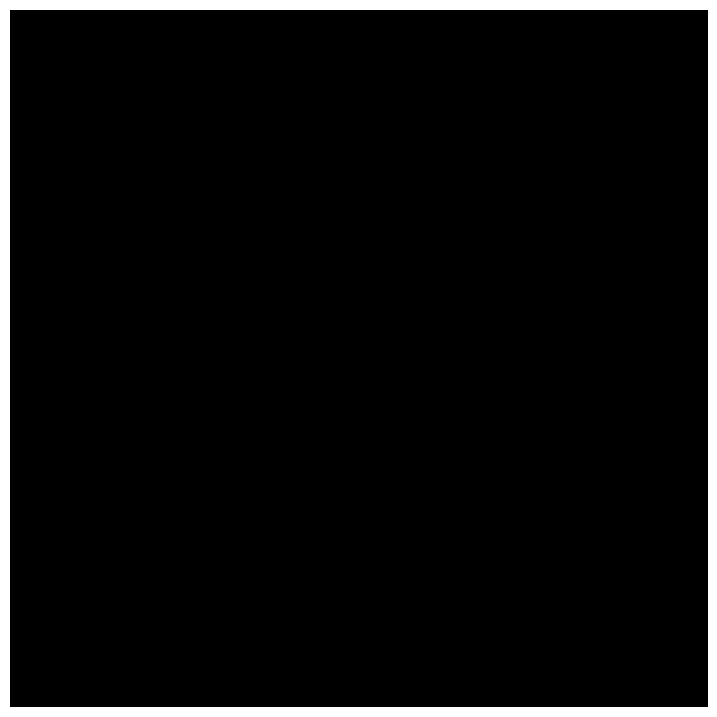

In [49]:
rend_img = visualize_mesh(torch.zeros(3,1000,1000), smpl=smpl_metro, cam_pose=cam_pose, cam_intr=cam_intr, vertices=verts_cam)
plot_tensor(rend_img)